# Model Arima for Time Series Forecasting temperature

## LLibreries

In [4]:
import json
import os
import sys
import time
import datetime
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [47]:
# Directori de treball

# Ruta on esta el script actual
# __path__ = os.path.dirname(os.path.realpath(__file__)) # Si es fitxer .py
__path__ = os.getcwd() # Si es fitxer .ipynb

carpeta_dades = 'Dades_T_estacions_xema_Z1'
fitxer_dades = 'SCM_T_Z1.json'

path_dades = os.path.join(os.getcwd(), carpeta_dades, fitxer_dades)


    # Obrir un arxiu json per veure com esta estructurat i com organitzar les dades
with open(path_dades, 'r') as f:
    data = json.load(f)

    # Accedemos a las lecturas (temperaturas) del JSON
lecturas = data[0]['variables'][0]['lectures']

#     # Convertimos las lecturas a un DataFrame con solo las columnas necesarias
df = pd.DataFrame(lecturas)[['data', 'valor']]


# Convertimos la columna 'data' a tipo datetime para análisis posterior
df['data'] = pd.to_datetime(df['data'])

df.head()


,data,valor
0,1998-01-01 00:00:00+00:00,-4.6
1,1998-01-01 01:00:00+00:00,-5.1
2,1998-01-01 02:00:00+00:00,-5.3
3,1998-01-01 03:00:00+00:00,-5.5
4,1998-01-01 04:00:00+00:00,-5.8


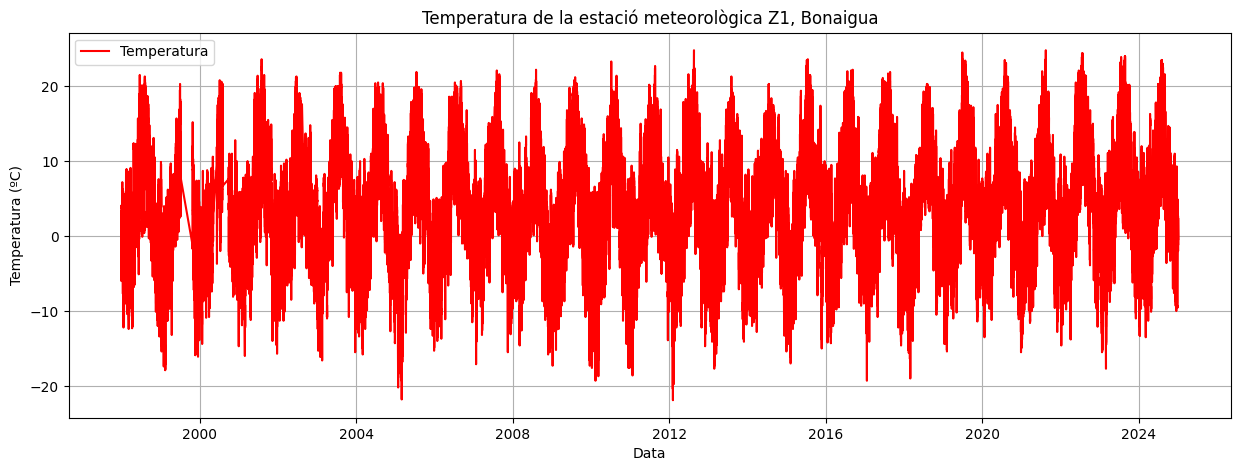

In [49]:
# Plot de les dades de temperatura de tota la serie temporal
plt.figure(figsize=(15, 5))
plt.plot(df['data'], df['valor'], label='Temperatura', color = 'red')
plt.title('Temperatura de la estació meteorològica Z1, Bonaigua')
plt.xlabel('Data')
plt.ylabel('Temperatura (ºC)')
plt.legend()
plt.grid()
plt.show()


In [52]:
# Intentem unificar les dades en promig de cada 6 hores.
# Es a dir, fem un dataframe on les dades que afegirem sera el promig del valor cada 6 hores. Per tant serà una entrada a les 6h, 12h, 18h i 24h.
# Respectant els horaris de les dades originals seria, per cada dia, interval de 00:00 a 05:59, 06:00 a 11:59, 12:00 a 17:59 i 18:00 a 23:59.

# Creem un nou dataframe per guardar les dades agrupades
df_agrupades = pd.DataFrame(columns=['data', 'valor'])

# Iterem per cada dia i agafem les dades de cada interval

for i in range(len(df['data'].dt.date.unique())):
    # Agafem la data d'entrada
    data_entrada = df['data'].dt.date.unique()[i]

    # Agafem les dades del dataframe original que son d'aquell dia
    df_dia = df[df['data'].dt.date == data_entrada]

    # Agafem les dades de cada interval i calculem el promig
    valor_00_06 = df_dia[(df_dia['data'].dt.hour >= 0) & (df_dia['data'].dt.hour < 6)]['valor'].mean()
    valor_06_12 = df_dia[(df_dia['data'].dt.hour >= 6) & (df_dia['data'].dt.hour < 12)]['valor'].mean()
    valor_12_18 = df_dia[(df_dia['data'].dt.hour >= 12) & (df_dia['data'].dt.hour < 18)]['valor'].mean()
    valor_18_24 = df_dia[(df_dia['data'].dt.hour >= 18) & (df_dia['data'].dt.hour < 24)]['valor'].mean()

    # Afegim les dades al nou dataframe
    df_agrupades = pd.concat([df_agrupades, pd.DataFrame({'data': [datetime.datetime.combine(data_entrada, datetime.time(0, 0))], 'valor': [valor_00_06]})], ignore_index=True)
    df_agrupades = pd.concat([df_agrupades, pd.DataFrame({'data': [datetime.datetime.combine(data_entrada, datetime.time(6, 0))], 'valor': [valor_06_12]})], ignore_index=True)
    df_agrupades = pd.concat([df_agrupades, pd.DataFrame({'data': [datetime.datetime.combine(data_entrada, datetime.time(12, 0))], 'valor': [valor_12_18]})], ignore_index=True)
    df_agrupades = pd.concat([df_agrupades, pd.DataFrame({'data': [datetime.datetime.combine(data_entrada, datetime.time(18, 0))], 'valor': [valor_18_24]})], ignore_index=True)

# Convertim la columna 'data' a datetime
df_agrupades['data'] = pd.to_datetime(df_agrupades['data'])
# Ordenem el dataframe per data
df_agrupades = df_agrupades.sort_values(by='data').reset_index(drop=True)
# Mostrem el dataframe
df_agrupades.head(10)


/tmp/ipykernel_11048/3444029903.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_agrupades = pd.concat([df_agrupades, pd.DataFrame({'data': [datetime.datetime.combine(data_entrada, datetime.time(0, 0))], 'valor': [valor_00_06]})], ignore_index=True)


KeyboardInterrupt: 

In [51]:
# Agafar només les dades corresponents als hiverns i posar-les en un nou dataframe
# Les dates dels hiverns seran del 1 de desembre al 31 de març
# df_hiverns = df[(df['data'].dt.month >= 11) | (df['data'].dt.month <= 2)]

# df_hiverns.head()

In [ ]:
# Estalblim les dades per entrenar el model fins al al hivern 2018-2019 inclos i testejarem amb les dades del hivern 2019-2020

# Per l'hivern 2018-2019 agafem fins nomes els mesos de gener i febrer del 2019. Els de novembre i desembre del 2019 ja formen part del següent hivern

# df_train = df_hiverns[
#     (df_hiverns['data'].dt.year < 2019) | 
#     ((df_hiverns['data'].dt.year == 2019) & (df_hiverns['data'].dt.month <= 2))]


# df_test = df_hiverns[
#     ((df_hiverns['data'].dt.year == 2019) & (df_hiverns['data'].dt.month >= 11)) | 
#     ((df_hiverns['data'].dt.year == 2020) & (df_hiverns['data'].dt.month <= 2))
# ]


# Entrenem


In [11]:
# ARIMA model

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

# Creem el model AutoARIMA
model = AutoARIMA()


In [ ]:
y = df_train['valor'].values


array([-4.6, -5.1, -5.3, ...,  0. , -0.6, -0.9])

In [18]:
model.fit(y)

AutoARIMA

In [23]:
# Veure dades del model
predicions = model.predict(len(df_test))

In [41]:
prediccio = predicions['mean']
print(prediccio)

[-0.94065579 -0.9188897  -0.86507663 ...  1.64751655  1.64751655
  1.64751655]


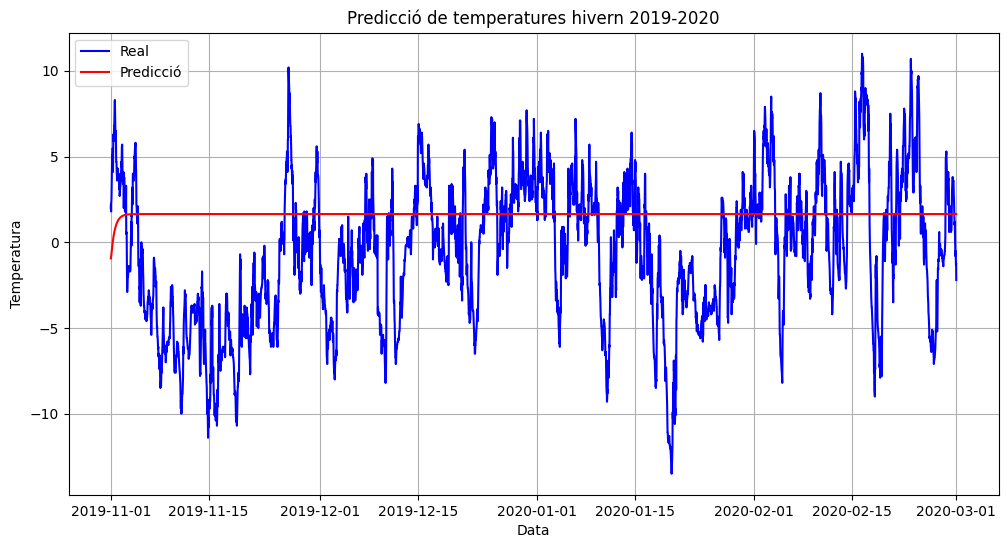

In [44]:
# Plot valors reals df_test['valor'] i prediccions

plt.figure(figsize=(12, 6))
plt.plot(df_test['data'], df_test['valor'], label='Real', color='blue')
plt.plot(df_test['data'], prediccio, label='Predicció', color='red')
plt.title('Predicció de temperatures hivern 2019-2020')
plt.xlabel('Data')
plt.ylabel('Temperatura')
plt.legend()
plt.grid()
plt.show()


# Model total, sense hiverns